This notebook illustrates basic use of the pyORAC utilities beyond command-line running of ORAC.

We will look at some of the regression test outputs. First, we will use `pyorac.definitions.FileName` to determine the name of the file we want to open.

In [1]:
# The name of the L1 Terra MODIS file is stored in the regression_tests module
from pyorac.regression_tests import REGRESSION_TESTS

terra_l1_filename, scene_limit, sensor = REGRESSION_TESTS["DAYMODS"]

# A class which parses L1 satellite filenames and converts between formats
from pyorac.definitions import FileName

terra_file_obj = FileName(terra_l1_filename)

# Your local defaults file specifies a folder for the regression test outputs
# and the filenaming conventions
from pyorac.local_defaults import REGRESS_IN_DIR, REGRESS_OUT_DIR, GLOBAL_ATTRIBUTES

import os.path

# Build a path to the file (use an appropriate revision number)
terra_rootname = terra_file_obj.root_name(
    revision=2315,
    processor=GLOBAL_ATTRIBUTES["processor"],
    project=GLOBAL_ATTRIBUTES["project"],
    product_name=GLOBAL_ATTRIBUTES["product_name"]
)

# I have subfolders for different compilers; you might not need that
terra_filepath = os.path.join(
    REGRESS_OUT_DIR, "conda_cld", "DAYMOD", terra_rootname + ".primary.nc"
)
if os.path.isfile(terra_filepath):
    print("Located " + terra_filepath)
    
# You can access details about the file
print(f"This {terra_file_obj.sensor}-{terra_file_obj.platform} image was captured "
      f"at {terra_file_obj.time:%Y-%m-%d %H:%M}")
print("Geolocation data is found in " + terra_file_obj.geo)
print("Batch processing this file will have the name " + terra_file_obj.job_name())

Located /network/aopp/matin/eodg/shared/orac/data/testoutput/conda_cld/DAYMOD/ESACCI-L2-CLOUD-CLD-MODIS_ORAC_TERRA_200806200115_R2315.primary.nc
This MODIS-TERRA image was captured at 2008-06-20 01:15
Geolocation data is found in MOD03.A2008172.0115.061.*hdf
Batch processing this file will have the name MODIS_TERRA_2008-06-20-01-15_R2391_run


Next, we demonstrate `pyorac.Swath`. This is a container for ORAC output files and contains methods for opening variables, masking data, and plotting. You can open variables using dictionary-style indexing. Basic information about the file can be printed.

ORAC file ESACCI-L2-CLOUD-CLD-MODIS_ORAC_TERRA_200806200115_R2315.primary.nc
2030x1354 swath starting at 2008-06-20 01:15:07 covering [122.00E, 148.07E], [-27.64N, -6.60N]
     n_not_converged: 110462.00
        n_qc_cleared: 192613.00
              costjm: 0.69
               niter: 5.47
                 cot: 6.89
                 cer: 13.51
                 cth: 2.58


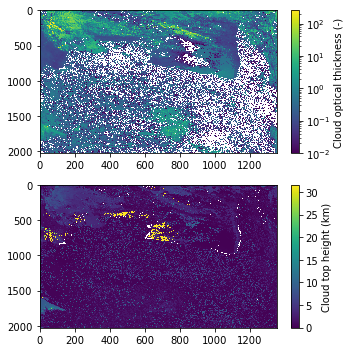

In [2]:
from pyorac import Swath

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Using a WITH clause will automatically close the files
with Swath(terra_filepath) as modis:
    cot = modis["cot"]
    cth = modis["cth"]

    print(modis)
    
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
im_cot = axes[0].imshow(cot, norm=LogNorm(), interpolation="none", aspect="auto")
_ = fig.colorbar(im_cot, ax=axes[0], label="Cloud optical thickness (-)")
im_cth = axes[1].imshow(cth, interpolation="none", aspect="auto")
_ = fig.colorbar(im_cth, ax=axes[1], label="Cloud top height (km)")
fig.tight_layout()

One of the main features of `Swath` is that it includes a method to plot fields on a map.

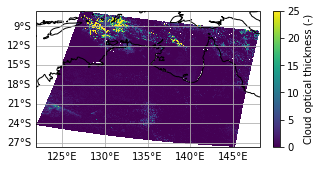

In [3]:
# Setup a simple cartopy map with labelled lat/lon
from cartopy.crs import PlateCarree
def simple_maps(y, x):
    fig, axes = plt.subplots(y, x, figsize=(5*x, 2.5*y), squeeze=False,
                             subplot_kw=dict(projection=PlateCarree()))
    for ax in axes.ravel():
        ax.coastlines()
        glines = ax.gridlines(draw_labels=True)
        glines.top_labels = False
        glines.right_labels = False
        ax.set_aspect("auto")

    if x*y == 1:
        return fig, axes[0,0]
    else:
        return fig, axes.squeeze()

modis = Swath(terra_filepath)

# The MAP method takes the same arguments as plt.pcolormesh
fig, ax = simple_maps(1, 1)
im_cot = modis.map(ax, cot, vmax=25)
_ = plt.colorbar(im_cot, label="Cloud optical thickness (-)")

# Used normally, you either need to close the swath or wait for garbage collection
modis.close()

If the scene crosses the dateline, the `Swath.central_longitude` attribute can be changed.

It is also possible to make false-colour plots.

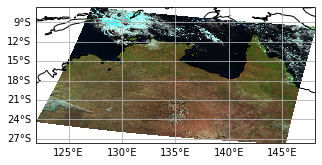

In [4]:
import numpy as np

# I will leave this open for now
modis = Swath(terra_filepath)

# Reflectance and brightness temperatures are stored in the secondary file
# which can be accessed using the Swath object. For a false-colour plot,
# we want Red = 1.6um, Green = 800 nm, Blue = 600 um which, for MODIS, are
# channels 6, 2, and 1.
colour = np.ma.stack([modis[f"reflectance_in_channel_no_{ch}"] for ch in (6,2,1)])

# vmin and vmax set the mimumum/maximum reflectance. Setting vmax=0.5
# brightens the image but can saturate cloud or ice.
fig, ax = simple_maps(1, 1)
_ = modis.false(ax, colour, vmax=0.5)

We can see that many of these pixels weren't suitable for a cloud retrieval. We can set a mask that will be applied to all fields when read.

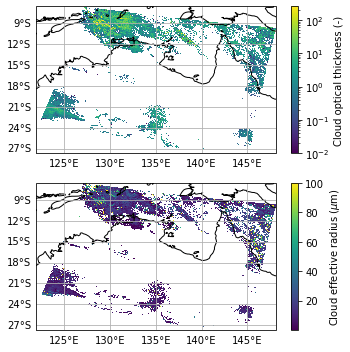

In [5]:
# The CLDMASK property uses the cldmask or cldtype variable, but will
# collapse both views of a dual-view sensor with .or.
modis.mask = ~modis.cldmask

fig, (ax0, ax1) = simple_maps(2, 1)
im_cot = modis.map(ax0, modis["cot"], norm=LogNorm())
_ = fig.colorbar(im_cot, ax=ax0, label="Cloud optical thickness (-)")
im_cer = modis.map(ax1, modis["cer"])
_ = fig.colorbar(im_cer, ax=ax1, label=r"Cloud effective radius ($\mu$m)")
fig.tight_layout()

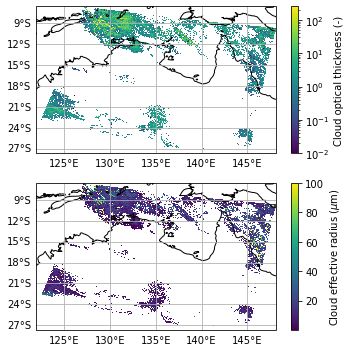

In [6]:
# The method mask_clear() combines cloud masking with
# some basic quality control for converged pixels
modis.mask = modis.mask_clear()

fig, (ax0, ax1) = simple_maps(2, 1)
im_cot = modis.map(ax0, modis["cot"], norm=LogNorm())
_ = fig.colorbar(im_cot, ax=ax0, label="Cloud optical thickness (-)")
im_cer = modis.map(ax1, modis["cer"])
_ = fig.colorbar(im_cer, ax=ax1, label=r"Cloud effective radius ($\mu$m)")
fig.tight_layout()

We can identify the ice clouds using the `phase` variable. The `flag_map()` method tells us the meaning of the different values of any mask variable.

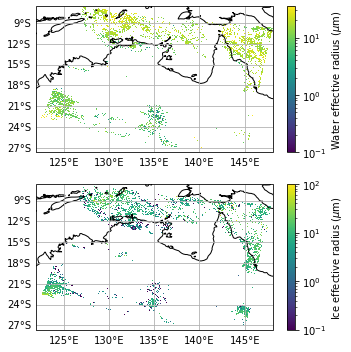

In [7]:
cer = modis["cer"]
phs = modis["phase"]
phs_label = modis.flag_map("phase", value_to_label=False)

fig, (ax0, ax1) = simple_maps(2, 1)
im_cot = modis.map(ax0, np.ma.masked_where(phs != phs_label["WAT"], cer),
                   norm=LogNorm())
_ = fig.colorbar(im_cot, ax=ax0, label="Water effective radius ($\mu$m)")
im_cer = modis.map(ax1, np.ma.masked_where(phs != phs_label["ICE"], cer),
                   norm=LogNorm())
_ = fig.colorbar(im_cer, ax=ax1, label=r"Ice effective radius ($\mu$m)")
fig.tight_layout()

Some useful calculations are also available, such as cloud droplet number concentration.

/network/aopp/matin/eodg/shared/orac/orac/tools/pyorac/swath.py:950: RuntimeWarning: invalid value encountered in sqrt
  return 1.37e-5 * np.sqrt(tau / r_e**5)


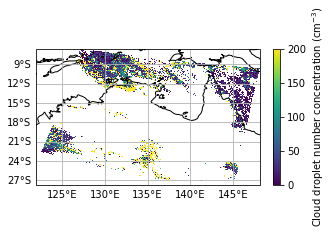

In [8]:
fig, ax = simple_maps(1, 1)
im_cdnc = modis.map(ax, modis.cdnc() * 1e-6, vmax=200)
_ = plt.colorbar(im_cdnc, label=r"Cloud droplet number concentration (cm$^{-3}$)")

# We're now done with this file
modis.close()

These calculations tend to be more relevant for aerosol retrievals. Let us open the SLSTR-A aerosol test and plot the retrieved surface reflectance as a false-colour image.

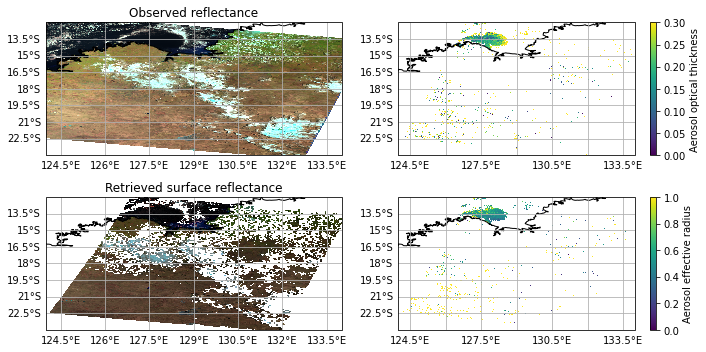

In [9]:
slstra_l1_filename, _, _ = REGRESSION_TESTS["DAYSLSTRA"]

# ORAC's SLSTR filenames include the orbit number, which isn't given in the
# L1B filename. Hence, we need to provide the location of the L1B file (or
# a full path) so it can be opened and the orbit number read. Alternatively,
# set it manually (though at that point you can just write out the filename
# rather than work it out using FileName)
slstra_file_obj = FileName(REGRESS_IN_DIR, slstra_l1_filename)

slstra_rootname = slstra_file_obj.root_name(
    revision=2315,
    processor=GLOBAL_ATTRIBUTES["processor"],
    project=GLOBAL_ATTRIBUTES["project"],
    product_name=GLOBAL_ATTRIBUTES["product_name"]
)
slstra_filepath = os.path.join(
    REGRESS_OUT_DIR, "conda_aer", "DAYSLSTRA", slstra_rootname + ".primary.nc"
)

fig, axes = simple_maps(2, 2)
with Swath(slstra_filepath) as slstra:
    # A false-colour as before
    colour = np.ma.stack([slstra[f"reflectance_in_channel_no_{ch}"] for ch in (5,3,2)])
    slstra.false(axes[0,0], colour, vmax=0.5)
    axes[0,0].set_title("Observed reflectance")
    
    # RS provides the surface reflectance in each channel, in ascending order.
    # It combines both treatments of surface reflectance into one output field.
    # To make a false-colour image, we use the ORDER keyword to subset the first
    # dimension of the surface_reflectance array. The default ORAC retrieval uses
    # channels 1, 2, 3, 5, 10, 11, 12, 14 of SLSTR. Hence, we want the 4th, 3rd
    # and 2nd elements of the array to make a false-colour from the nadir.
    surface_reflectance = slstra.rs
    slstra.false(axes[1,0], surface_reflectance, order=(3,2,1))
    axes[1,0].set_title("Retrieved surface reflectance")
    
    # The removal of cloud from aerosol retrievals is more involved than that
    # for clouds. A series of tests are applied, summarised in CLDFLAG. They
    # can be ignored with the ALLOWING keyword. Here, we skip stdev (throws out
    # pixels where the standard deviation of AOT is > 0.1) and opening tests on
    # the AOT and AER fields (a morphographic filter that flags salt-and-pepper
    # noise). Values for the flag are stored in pyorac.swath.CLDFLAG. Thresholds
    # can be set by calling Swath.set_cldflag directly.
    slstra.mask = slstra.mask_cloud(allowing=("stdev", "openaot", "openaer"))
    
    im_aot = slstra.map(axes[0,1], slstra["aot550"], vmin=0, vmax=0.3)
    fig.colorbar(im_aot, ax=axes[0,1], label="Aerosol optical thickness")
    
    im_aer = slstra.map(axes[1,1], slstra["aer"], vmin=0, vmax=1.0)
    fig.colorbar(im_aer, ax=axes[1,1], label="Aerosol effective radius")
    
for ax in axes.ravel():
    ax.set_extent((124, 134, -24, -12))
    
fig.tight_layout()

There isn't much aerosol to see because (a) the retrieval is only performed where both views are available, (b) that doesn't include much sea where the aerosol retrieval performs better, (c) the scene is variously cloudy or over desert so aerosol retrieval struggles. We can see from the difference between the lower two images that a retrieval was attempted in most of the scene but failed for various reasons.

The Angstrom exponents (`Swath.ang`) and cloud thickness (`Swath.thickness`) are also available.

Finally, we'll illustrate how to plot geostationary images on a map as it isn't obvious using cartopy.

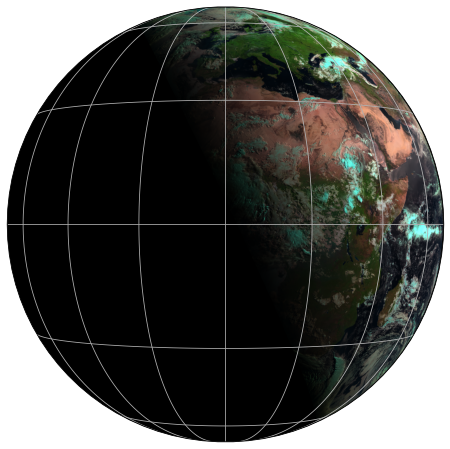

In [10]:
from cartopy.crs import Geostationary

# There is presumably a way to derive these numbers but I don't know it
seviri_crs = Geostationary(satellite_height=35786000.0)
EXTENT = (5568748.0, -5568748.0, -5568748.0, 5568748.0)

seviri_l1_filename, _, _ = REGRESSION_TESTS["SEVIRI"]

seviri_file_obj = FileName(REGRESS_IN_DIR, seviri_l1_filename)

seviri_rootname = seviri_file_obj.root_name(
    revision=2315,
    processor=GLOBAL_ATTRIBUTES["processor"],
    project=GLOBAL_ATTRIBUTES["project"],
    product_name=GLOBAL_ATTRIBUTES["product_name"]
)
seviri_filepath = os.path.join(
    REGRESS_OUT_DIR, "conda_cld", "SEVIRI", seviri_rootname + ".primary.nc"
)

# If you don't want to plot maps, the QUICK_OPEN keyword skips that calculation.
# Here, that avoids various warnings because geostationary scenes contain many
# invalid coordinates (where it sees space).
with Swath(seviri_filepath, quick_open=True) as seviri:
    # plt.imshow() wants the channels in the last dimension; hence axis=2
    colour = np.ma.stack(
        [seviri[f"reflectance_in_channel_no_{ch}"] for ch in (3,2,1)], axis=2
    )

# Apply the VMAX we used in the earlier false-colour plots
thresholded_colour = np.ma.maximum(np.ma.minimum(colour, 0.5)/0.5, 0.0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw=dict(projection=seviri_crs))
ax.imshow(thresholded_colour, extent=EXTENT, origin="lower")
ax.gridlines()
ax.set_global() # Points everything the right way around